# Multi class PET classifier

This section tries to replicate the results form [FASTAI Pet Breeds](https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb), creating a multi class classifier using pretrained resnet.

The approaches that are to be used in this notebook include
- Creating Train/Valid data from the image folders
- Applying CrossEntropy Loss (SoftMax + Negative log loss)
- Understanding the issues with the data (With Confusion Matrix)
- Getting the best learning rate for our resnet (Using learn optimizer)
- Using learn rate discriminators to improve the learning only on the more complex deeper layers
- Finding the correct Epoch count
- Using more complex (Deeper) model to improve accuracy


In [1]:
!pip install -q fastbook
from fastbook import *

In [2]:
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [3]:
# Lets take a look at how the data looks like
(path/'images').ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_56.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Siamese_61.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_66.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/shiba_inu_55.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_68.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_153.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_57.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pug_182.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Siamese_182.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_100.jpg')...]

In [5]:
# Adding batch group transform calculates all the transforms at once on the GPU + interpolation is done all at the end, so avoids anhy problematic pixels.

db = DataBlock((ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=using_attr(RegexLabeller(r'(.+)_\d+\.jpg'), 'name'),
    splitter = RandomSplitter(),
    item_tfms = Resize(480),
    batch_tfms = aug_transforms(size=220, min_scale=0.7)
)
dls = db.dataloaders(path/'images')

In [6]:
# Contains the available vocab
dls.vocab

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

In [7]:
# Contains all the data comming in to the data loader
dls.dataset

(#5912) [(PILImage mode=RGB size=300x225, TensorCategory(29)),(PILImage mode=RGB size=434x500, TensorCategory(7)),(PILImage mode=RGB size=500x375, TensorCategory(14)),(PILImage mode=RGB size=500x333, TensorCategory(25)),(PILImage mode=RGB size=500x375, TensorCategory(32)),(PILImage mode=RGB size=762x571, TensorCategory(4)),(PILImage mode=RGB size=500x375, TensorCategory(24)),(PILImage mode=RGB size=333x500, TensorCategory(25)),(PILImage mode=RGB size=500x333, TensorCategory(16)),(PILImage mode=RGB size=400x500, TensorCategory(14))...]

In [8]:
# Use summary to get better feeling of how the processing of datablock will go on.
# Also allows you to catch preemeptively bugs
db.summary(path/'images')

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Ragdoll_44.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x333
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/Ragdoll_44.jpg
    applying partial gives
      Ragdoll
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(8)

Final sample: (PILImage mode=RGB size=500x333, TensorCategory(8))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipeline:

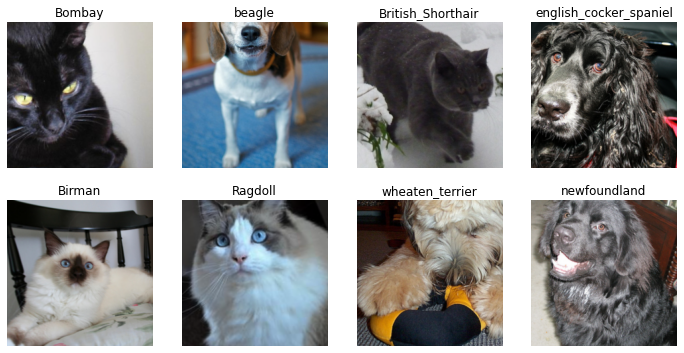

In [9]:
# Always make sure that the lables are correctly attached. Easiest way is to just display a sample from the batch.

dls.show_batch(nrows=2, ncols=4)

<AxesSubplot:>

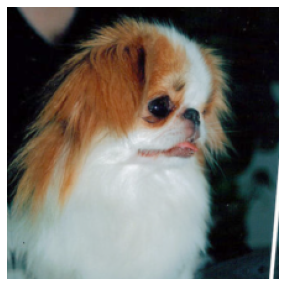

In [10]:
# Lets take a look at just one image and see how we can accesss the labels for it as well from the dataloader
x,y =dls.one_batch()
x[0].show()

# Accessing the target of the image
print(dls.vocab[y[0]])

In [12]:
# We need to get the 1 best prediction, that is the expected label.
# Therefore we run argmax on the prediction.
# Then we compare that to the expected (Creating Boolean), and getting mean of all Trues provides us with the percentage

def get_accuracy(predict, expected, axis=-1):
    normalized = predict.argmax(dim=axis)
    return (normalized == expected).float().mean()

In [16]:
# Lets start with a really small model (18layers) and just get a feeling for what we are doing
learn = vision_learner(dls, models.resnet18, loss_func=CrossEntropyLossFlat(), metrics=get_accuracy)
learn.fine_tune(5)

epoch,train_loss,valid_loss,get_accuracy,time
0,1.642673,0.442635,0.853180,00:34


epoch,train_loss,valid_loss,get_accuracy,time
0,0.602965,0.329567,0.893775,00:40
1,0.468366,0.347626,0.890392,00:40
2,0.360580,0.261252,0.911367,00:40
3,0.246463,0.242912,0.920162,00:40
4,0.181129,0.235582,0.921516,00:40


In [17]:
?learn.predict

Signature: learn.predict(item, rm_type_tfms=None, with_input=False)
Docstring: Prediction on `item`, fully decoded, loss function decoded and probabilities
File:      /usr/local/lib/python3.9/dist-packages/fastai/learner.py
Type:      method


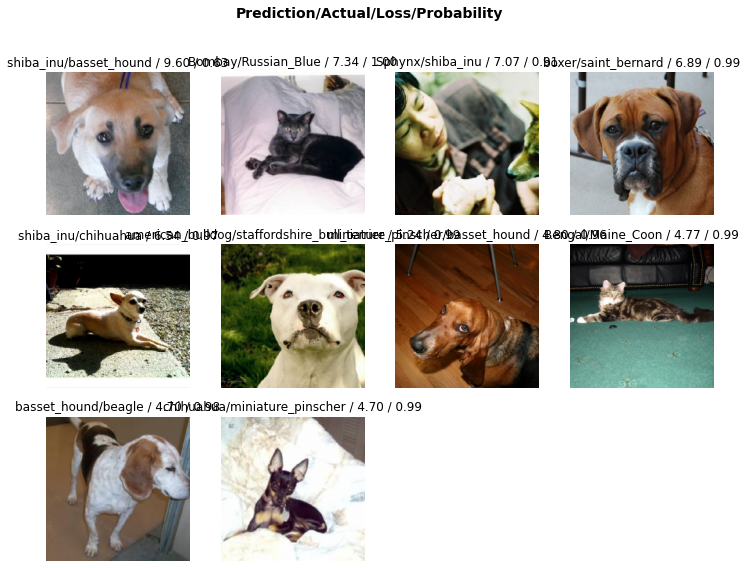

In [20]:
# Lets take a look at the most faulty predictions

interpreter = Interpretation.from_learner(learn)
interpreter.plot_top_losses(10);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Accuracy:  0.0


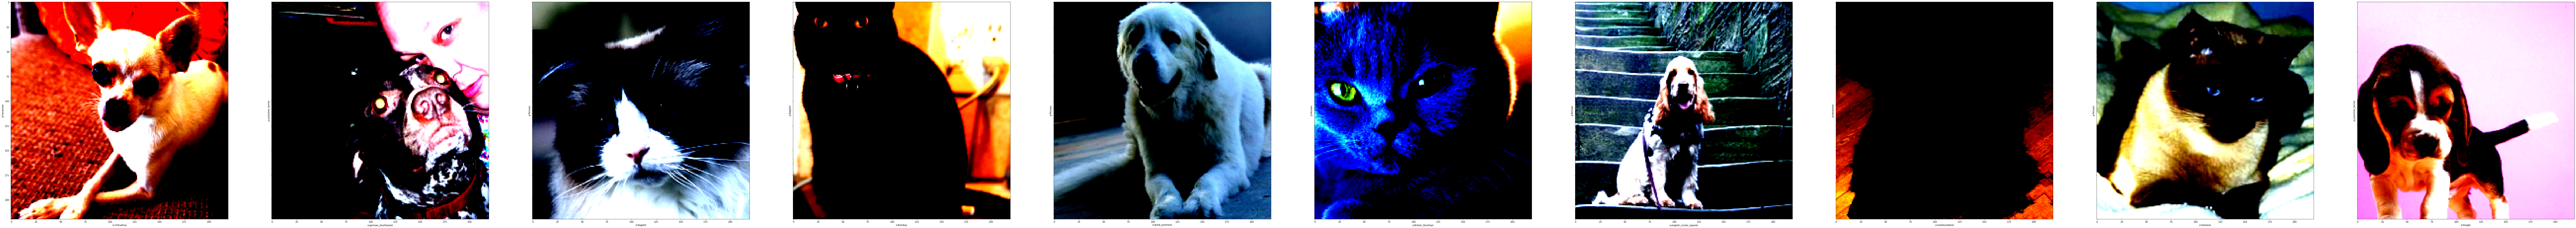

In [33]:
import numpy as np
# Lets validate on the existing batch
x,y = dls.one_batch()

max_amount_to_check = 10;

# Inspect the predicted value, This doesn't seem correct mainly if hte trainign is reportin 80% accuracy
predictions = np.array([learn.predict(to_cpu(i))[0] for i in x[:max_amount_to_check]])
true = np.array([dls.vocab[i] for i in y[:max_amount_to_check]])
total = (predictions == true).mean()

In [ ]:
# Should render out an plot with Image + expected/predicted labels
fig, ax = plt.subplots(1, max_amount_to_check, sharey=True, figsize=(200, 200))

for i in range(max_amount_to_check):
    predicted = predictions[i]
    ax[i].imshow(to_cpu(x[i]).permute(1, 2, 0))
    ax[i].set_xlabel('e:'+true[i])
    ax[i].set_ylabel('p:'+predictions[i])

# Double Click on the rendered image to see it whole

## After validating some of the results we can move to improvement of the model

We should consider improving the learning rate (optimize for faster learning). The default is 0.001 in FastAI.

SuggestedLRs(valley=5.248074739938602e-05)

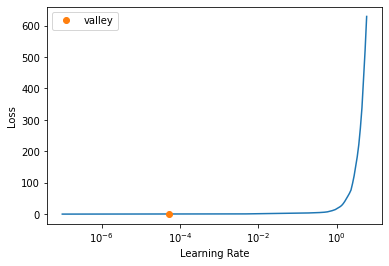

In [37]:
learn.lr_find(stop_div=False, num_it=200)

In [61]:
# Looking ath the graph our 0.001 might be indeed a good LR. Ill try a bit higher one, but I don't expect too much improvement
learn = vision_learner(dls, models.resnet18, loss_func=CrossEntropyLossFlat(), metrics=get_accuracy)

improved_learning_rate = 3e-3
learn.fine_tune(3, improved_learning_rate)

epoch,train_loss,valid_loss,get_accuracy,time
0,1.437268,0.387971,0.872801,00:33


epoch,train_loss,valid_loss,get_accuracy,time
0,0.558280,0.376246,0.873478,00:40
1,0.423137,0.279356,0.908660,00:41
2,0.268132,0.261586,0.914750,00:41


# We could improve the learning speed & precision by discriminative learning rates

So to train the early layers with smaller learning rate & later with higher.
Take a look here at [ULMfit](https://docs.fast.ai/tutorial.text.html#the-ulmfit-approach) for reference

We may want to consider using a bigger (deeper) model as we might have hit the cap with the 92% in the 18layer one.
Also using the discriminative training we can faster train the head, create a checkpoint and continue training on the body.

In [59]:
learn = vision_learner(dls, models.resnet34, loss_func=CrossEntropyLossFlat(), metrics=get_accuracy)
# First run training only on the head of the model
learn.freeze()
learn.fit_one_cycle(4, 3e-3) # The fourth iteration drops loss a bit but not the accuracy. Makes me wonder whether it makes sense
learn.save('headTrained1') # create local checkpoint so we don't need to run the head tuning multiple times when experimenting

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,get_accuracy,time
0,1.254808,0.403138,0.876184,00:47
1,0.589926,0.321943,0.900541,00:48
2,0.360765,0.259197,0.918133,00:47
3,0.277360,0.234477,0.924222,00:47


Path('models/headTrained1.pth')

In [62]:
learn = vision_learner(dls, models.resnet34, loss_func=CrossEntropyLossFlat(), metrics=get_accuracy)
learn.load('headTrained1');
# Then run on the rest of the model, but lets create a smaller learning rates for the earlier layers, and higher for the later.
learn.unfreeze()
lower_learning_rate = 1e-6
higher_learning_rate = 3e-4
# We could potentionally use the previous checkpoint and fit one cycle to fine tune the model
learn.fit_one_cycle(4, lr_max=slice(lower_learning_rate,higher_learning_rate))

epoch,train_loss,valid_loss,get_accuracy,time
0,0.245683,0.267591,0.915426,01:01
1,0.213716,0.219980,0.929635,01:01
2,0.184266,0.224051,0.931664,01:01
3,0.156747,0.217067,0.931664,01:01


In [ ]:
**We can see that the deeper model performs better in the longrun compared to the smaller one**.
Even though we could say that 1% is diminishing result, it really depends on our usecase. If training the deeper model is more costly, and has a unbeareable latency, the 18 one might be enough with correctly tuned parameters.